In [2]:
import numpy as np
import cv2
import SimpleITK as sitk
import matplotlib.pyplot as plt
import os

In [1]:
def get_patches1(image, breast_mask, patch_size=224, stride=112):
    patches, breast_mask_patches, locations = [], [], []
    img_height, img_width = image.shape[:2]

    # Calculate the number of patches in each dimension
    num_patches_x = (img_width - patch_size) // stride + 1
    num_patches_y = (img_height - patch_size) // stride + 1

    # Pad the image if necessary
    pad_x = (num_patches_x + 1) * stride + patch_size - img_width
    pad_y = (num_patches_y + 1) * stride + patch_size - img_height

    if pad_x > 0 or pad_y > 0:
        image = cv2.copyMakeBorder(image, 0, pad_y, 0, pad_x, cv2.BORDER_CONSTANT, value=0)
        breast_mask = cv2.copyMakeBorder(breast_mask, 0, pad_y, 0, pad_x, cv2.BORDER_CONSTANT, value=0)

    for y in range(0, img_height - patch_size + 1, stride):
        for x in range(0, img_width - patch_size + 1, stride):
            breast_mask_patch = breast_mask[y:y+patch_size, x:x+patch_size]
            if np.sum(breast_mask_patch) > thd:
                img_patch = image[y:y+patch_size, x:x+patch_size]
                patches.append(img_patch)
                locations.append([y, y+patch_size, x, x+patch_size])
                breast_mask_patches.append(breast_mask_patch)

    return patches, breast_mask_patches, locations

In [5]:
def get_patches(contrast, non_contrast, mask, thd, patch_size=224, stride=112):
    
    mask[mask>=1]=1      
    contrast_patches, non_contrast_patches, mask_patches, locations = [], [], [], []
    img_height, img_width = contrast.shape

    # Calculate the number of patches in each dimension
    num_patches_x = (img_width - patch_size) // stride + 1
    num_patches_y = (img_height - patch_size) // stride + 1

    # Pad the image if necessary
    pad_x = (num_patches_x + 1) * stride + patch_size - img_width
    pad_y = (num_patches_y + 1) * stride + patch_size - img_height

    if pad_x > 0 or pad_y > 0:
        contrast = cv2.copyMakeBorder(contrast, 0, pad_y, 0, pad_x, cv2.BORDER_CONSTANT, value=0)
        non_contrast = cv2.copyMakeBorder(non_contrast, 0, pad_y, 0, pad_x, cv2.BORDER_CONSTANT, value=0)
        mask = cv2.copyMakeBorder(mask, 0, pad_y, 0, pad_x, cv2.BORDER_CONSTANT, value=0)
    
    for y in range(0, img_height - patch_size + 1, stride):
        for x in range(0, img_width - patch_size + 1, stride):
            mask_patch = mask[y:y+patch_size, x:x+patch_size]
            if np.sum(mask_patch) > thd:
                contrast_patch = contrast[y:y+patch_size, x:x+patch_size]
                contrast_patches.append(contrast_patch)
                non_contrast_patch = non_contrast[y:y+patch_size, x:x+patch_size]
                non_contrast_patches.append(non_contrast_patch)
                locations.append([y, y+patch_size, x, x+patch_size])
                mask_patches.append(mask_patch)

    return  contrast_patches, non_contrast_patches, mask_patches, locations

In [99]:
image_path = r'C:\Users\qzhuang4\Desktop\Orca2d New\image\tev3p2\ARTERIAL\25.nii'
image = sitk.GetArrayFromImage(sitk.ReadImage(image_path))
mask = sitk.GetArrayFromImage(sitk.ReadImage(image_path.replace('image','label')))
patches, mask_patches, locations = get_patches(image, mask, thd, patch_size=128, stride=64)

8

In [31]:
def global_standardize_array(arr):
    global_mean = np.mean(arr)
    global_std = np.std(arr)
    standardized_arr = (arr - global_mean) / global_std
    return standardized_arr
 
# Example usage
arr = np.array([[1, 2], [3, 4]])
standardized_arr = global_standardize_array(arr)
print(standardized_arr)

[[-1.34164079 -0.4472136 ]
 [ 0.4472136   1.34164079]]


In [14]:
root =r'C:\Users\qzhuang4\Desktop\Orca2d New\image'
thd = 128 * 128 * 0.25 
for root, dirs, files in os.walk(root):
    for file in files:
        path = os.path.join(root,file)
        if 'ARTERIAL' in path:
            contrast = sitk.GetArrayFromImage(sitk.ReadImage(path))
            non_contrast = sitk.GetArrayFromImage(sitk.ReadImage(path.replace('ARTERIAL','NATIVE'))) 
            mask = sitk.GetArrayFromImage(sitk.ReadImage(path.replace('image','label')))
            contrast_patches, non_contrast_patches, mask_patches, locations = get_patches(contrast,non_contrast,mask,thd, patch_size=256, stride=64)  
            assert len(contrast_patches) == len(non_contrast_patches)
            count = 0     
            for patch in contrast_patches:
                patch = global_standardize_array(patch)
            #     patch_img = sitk.GetImageFromArray(patch)
            #     out_dir = root.replace('image','image patch 256')
            #     if not os.path.exists(out_dir):
            #         os.makedirs(out_dir)
            #     out_path = os.path.join(out_dir,file.split('.')[0]+'_'+'patch'+str(count) + ".nii")
            #     sitk.WriteImage(patch_img,out_path)
            #     count += 1
            # count = 0
            # for patch in non_contrast_patches:
            #     patch = 
            #     patch_img = sitk.GetImageFromArray(patch)
            #     out_dir = root.replace('image','image patch 256').replace('ARTERIAL','NATIVE')
            #     if not os.path.exists(out_dir):
            #         os.makedirs(out_dir)
            #     out_path = os.path.join(out_dir,file.split('.')[0]+'_'+'patch'+str(count) + ".nii")
            #     sitk.WriteImage(patch_img,out_path)
            #     count += 1

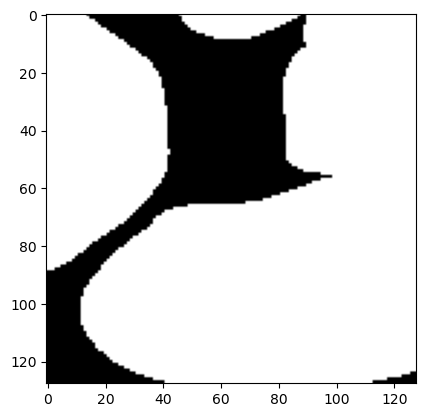

In [95]:
plt.imshow(mask_patches[19],cmap='gray')

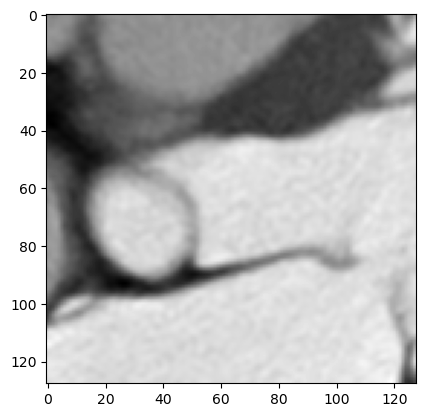

In [98]:
plt.imshow(patches[13],cmap='gray')

In [30]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def visualize_nifti_segmentation_slices(image_path, mask_path, alpha=0.8,
                                        class_labels=None, class_colors=None,
                                        start_slice=None, end_slice=None, step=1):
    """
    Visualize slices from a 3D NIfTI image with its multi-class segmentation mask overlaid.
    
    :param image_path: Path to the NIfTI image file.
    :param mask_path: Path to the NIfTI segmentation mask file.
    :param alpha: Transparency factor for the mask overlay.
    :param class_labels: List of labels for each class (including background).
    :param class_colors: List of colors for each class in RGB format.
    :param start_slice: Starting index of the slices to visualize.
    :param end_slice: Ending index of the slices to visualize.
    :param step: Step size between slices.
    """
    # Load the NIfTI image using SimpleITK
    try:
        image = sitk.ReadImage(image_path)
        image_array = sitk.GetArrayFromImage(image)
    except Exception as e:
        raise IOError(f"Error reading NIfTI image file: {e}")

    # Load the segmentation mask using SimpleITK
    try:
        mask = sitk.ReadImage(mask_path)
        mask_array = sitk.GetArrayFromImage(mask)
        mask_array[mask_array == 6] = 0
        # mask_array[mask_array == 5] = 5
    except Exception as e:
        raise IOError(f"Error reading NIfTI mask file: {e}")

    # Ensure that the dimensions match between the image and mask
    if image_array.shape != mask_array.shape:
        raise ValueError("NIfTI image and segmentation mask must have the same dimensions")

    # Determine the slice range
    num_slices = image_array.shape[0]
    if start_slice is None:
        start_slice = 0
    if end_slice is None or end_slice > num_slices:
        end_slice = num_slices

    # Determine the unique classes in the mask
    unique_classes = np.unique(mask_array)
    num_classes = len(unique_classes)

    # Set default class labels if not provided
    if class_labels is None:
        class_labels = [f"Class {int(c)}" if c != 0 else "Background" for c in unique_classes]

    # Set default colors if not provided
    if class_colors is None:
        # Use predefined colors for consistency
        predefined_colors = [
            (0, 0, 0),        # Background - black
            (255, 0, 0),      # Class 1 - red
            (0, 255, 0),      # Class 2 - green
            (0, 0, 255),      # Class 3 - blue
            (255, 255, 0),    # Class 4 - yellow
            (255, 0, 255),    # Class 5 - magenta
            # (0, 255, 255),    # Class 6 - cyan
            (128, 128, 128),  # Class 6 - gray
            # Add more colors if needed
        ]
        if num_classes > len(predefined_colors):
            # Extend colors with random colors if necessary
            additional_colors = np.random.randint(0, 255, size=(num_classes - len(predefined_colors), 3))
            class_colors = predefined_colors + additional_colors.tolist()
        else:
            class_colors = [predefined_colors[int(c)] for c in unique_classes]
    else:
        if len(class_colors) < num_classes:
            raise ValueError("Not enough colors provided for the number of classes")

    # Create a legend
    legend_handles = []
    for idx, class_value in enumerate(unique_classes):
        if class_value == 0:
            continue  # Skip background in legend
        color = np.array(class_colors[idx]) / 255  # Normalize color values for matplotlib
        patch = mpatches.Patch(color=color, label=class_labels[idx])
        legend_handles.append(patch)

    # Loop over slices
    for slice_index in range(start_slice, end_slice, step):
        image_slice = image_array[slice_index]
        mask_slice = mask_array[slice_index]

        # Normalize the image slice
        image_slice = image_slice.astype(np.float32)
        image_slice -= image_slice.min()
        if image_slice.max() != 0:
            image_slice /= image_slice.max()
        image_slice = (image_slice * 255).astype(np.uint8)

        # Convert grayscale image to RGB for visualization
        image_rgb = np.stack([image_slice]*3, axis=-1)

        # Create a color mask based on the class labels in the segmentation mask
        color_mask = np.zeros_like(image_rgb)
        for idx, class_value in enumerate(unique_classes):
            if class_value == 0:
                continue  # Skip background
            color = class_colors[idx]
            color_mask[mask_slice == class_value] = color

        # Overlay the color mask onto the original image with increased opacity
        overlayed_image = (1 - alpha) * image_rgb + alpha * color_mask
        overlayed_image = overlayed_image.astype(np.uint8)

        # Display the result
        plt.figure(figsize=(8, 8))
        plt.imshow(overlayed_image)
        plt.axis('off')  # Hide the axis
        if legend_handles:
            plt.legend(handles=legend_handles, loc='upper right', fontsize='large')
        plt.title(f'NIfTI Image with Segmentation Mask - Slice {slice_index}')
        plt.show()



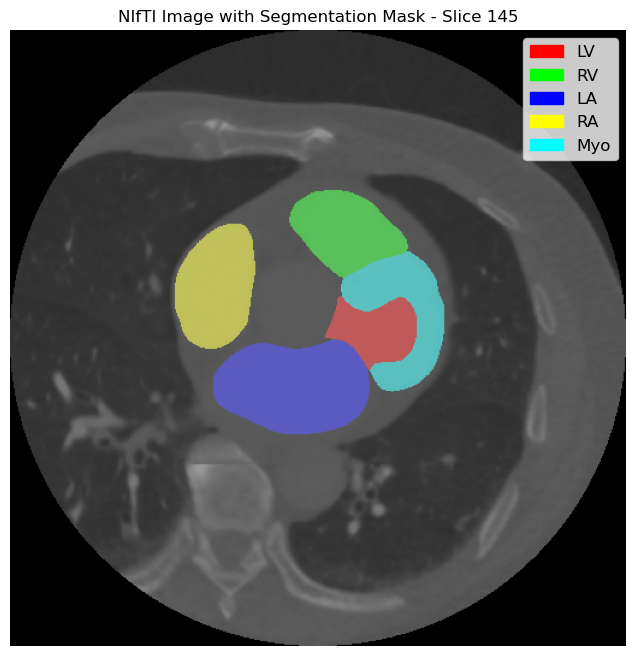

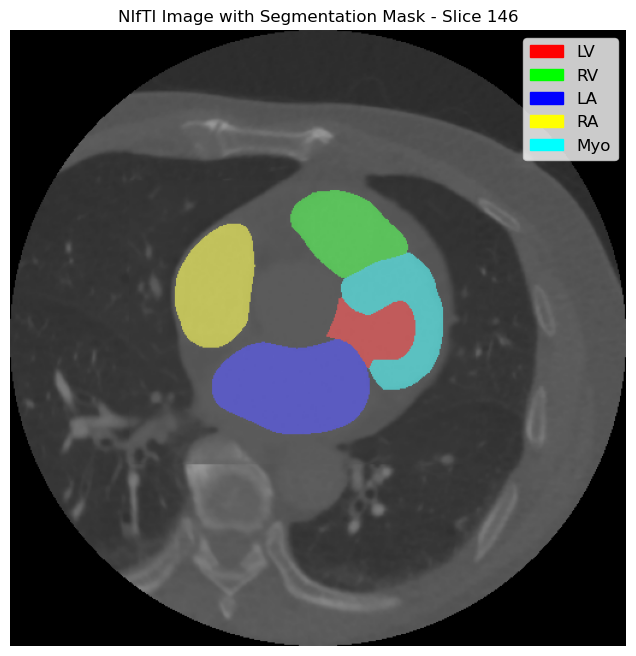

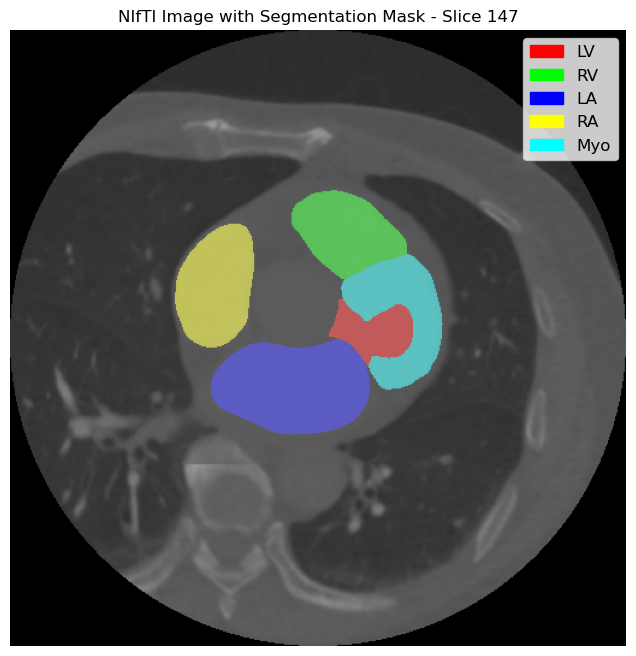

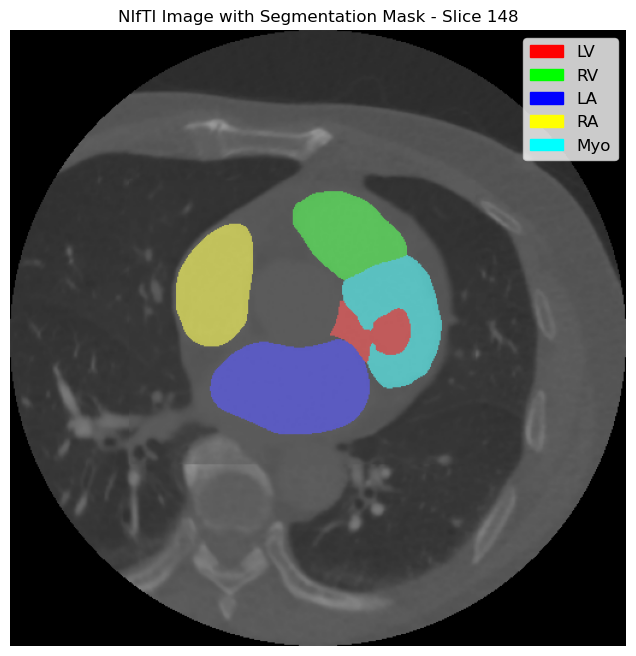

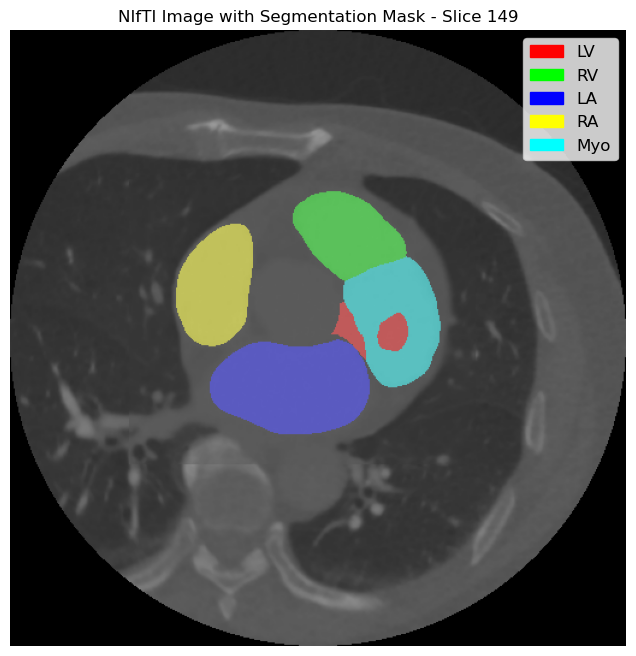

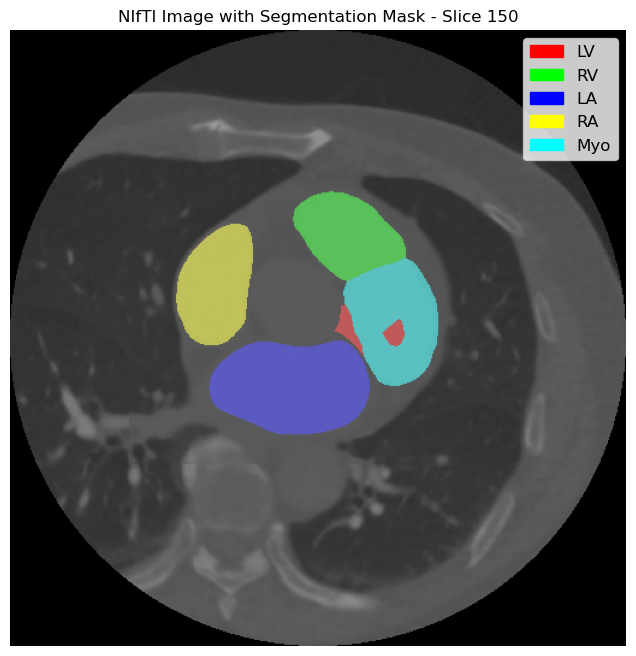

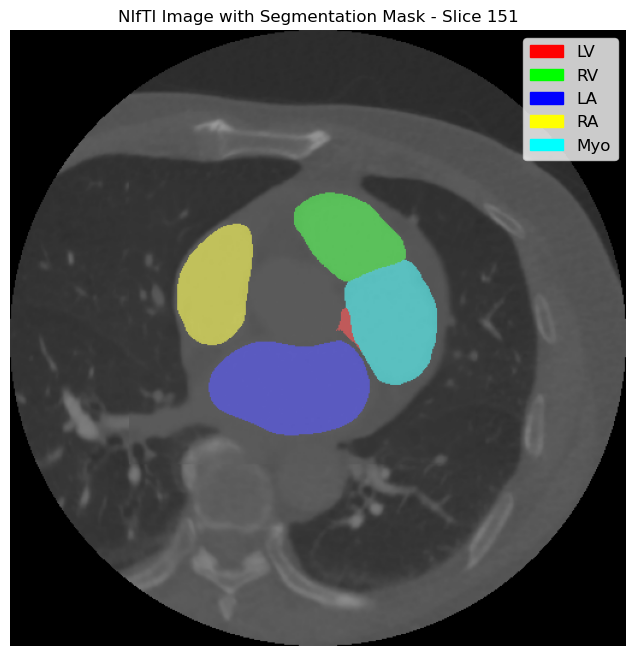

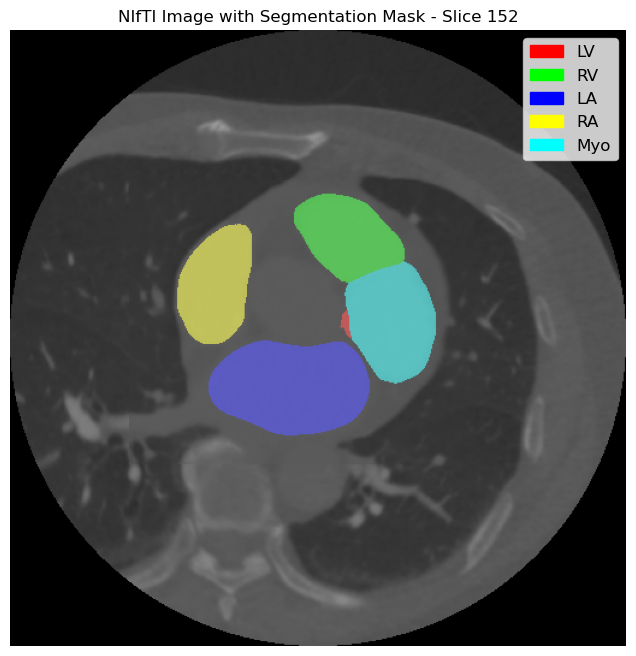

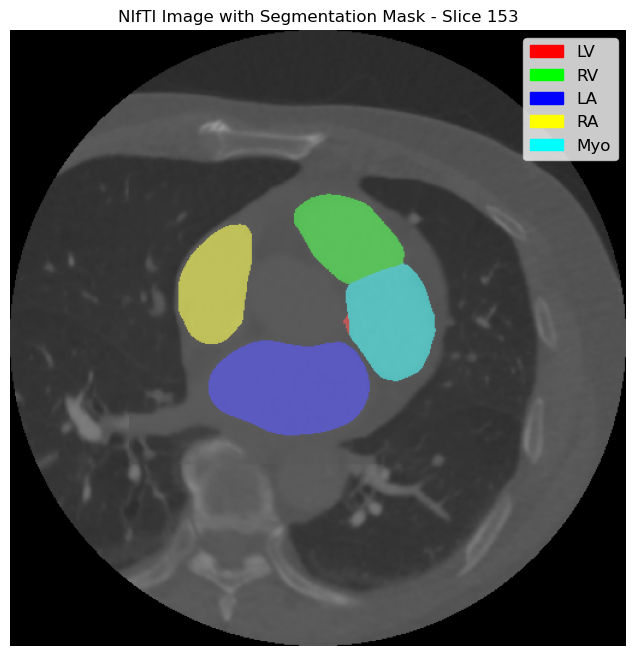

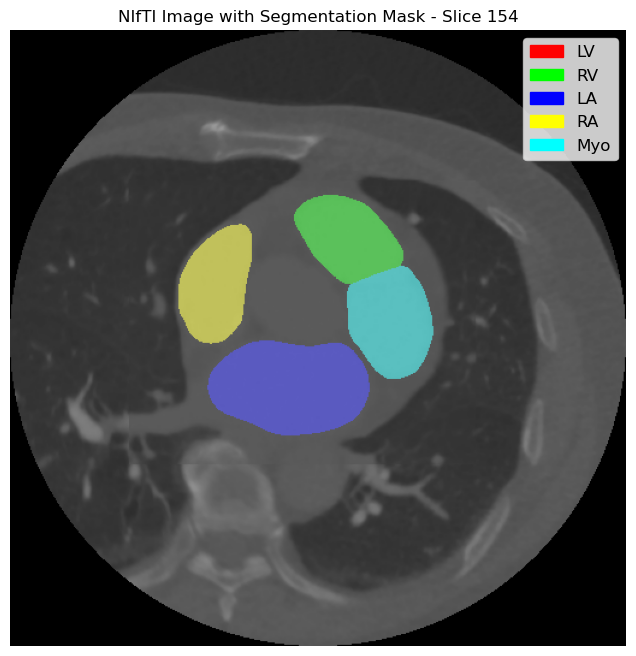

In [31]:
# Define paths to your NIfTI image and mask
image_path = r'C:\Users\qzhuang4\Desktop\cycle-transformer\results\10_rest_v2_0000.nii'
mask_path = r'C:\Users\qzhuang4\Desktop\cycle-transformer\results\10_rest_v2.nii'

# Define class labels and colors (modify as per your classes)
class_labels = ['Background', 'LV', 'RV', 'LA', 'RA', 'Myo']
class_colors = [
    (0, 0, 0),        # Background - black
    (255, 0, 0),      # Class 1 - red
    (0, 255, 0),      # Class 2 - green
    (0, 0, 255),      # Class 3 - blue
    (255, 255, 0),    # Class 4 - yellow
    # (255, 0, 255),    # Class 5 - magenta
    (0, 255, 255),    # Class 5 - cyan
]

# Visualize slices from index 50 to 60
visualize_nifti_segmentation_slices(
    image_path=image_path,
    mask_path=mask_path,
    alpha=0.4,
    class_labels=class_labels,
    class_colors=class_colors,
    start_slice=145,
    end_slice=155,
    step=1  # Visualize every slice in the range
)


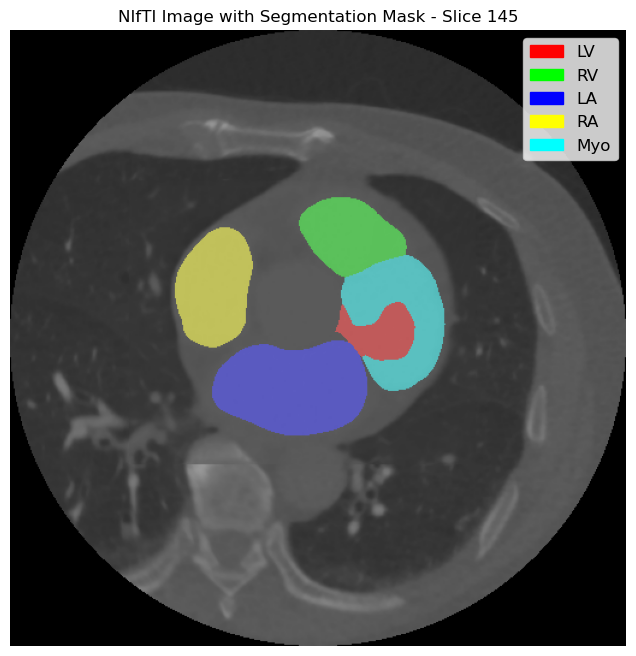

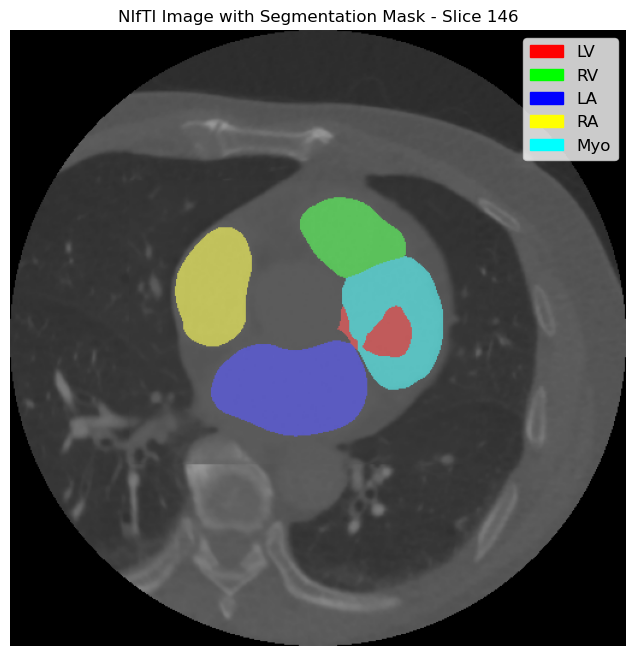

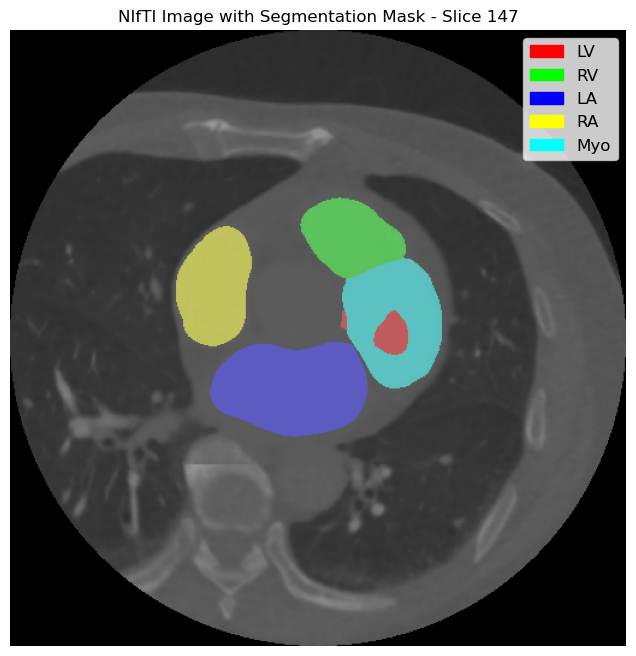

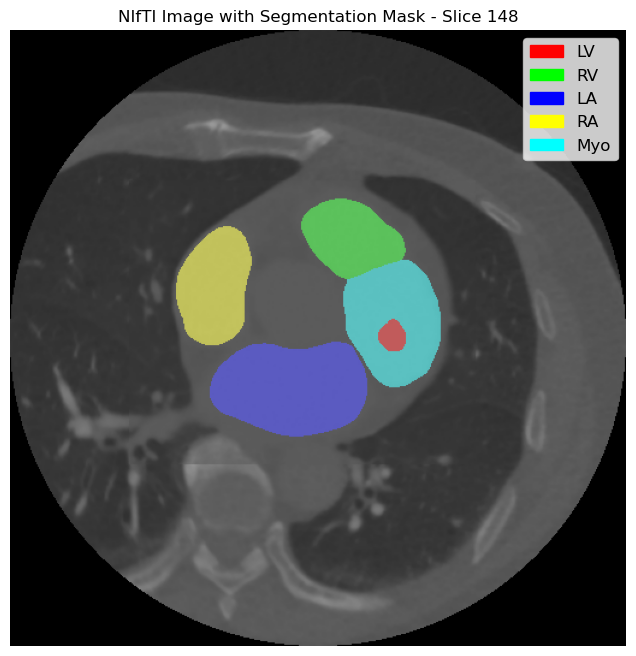

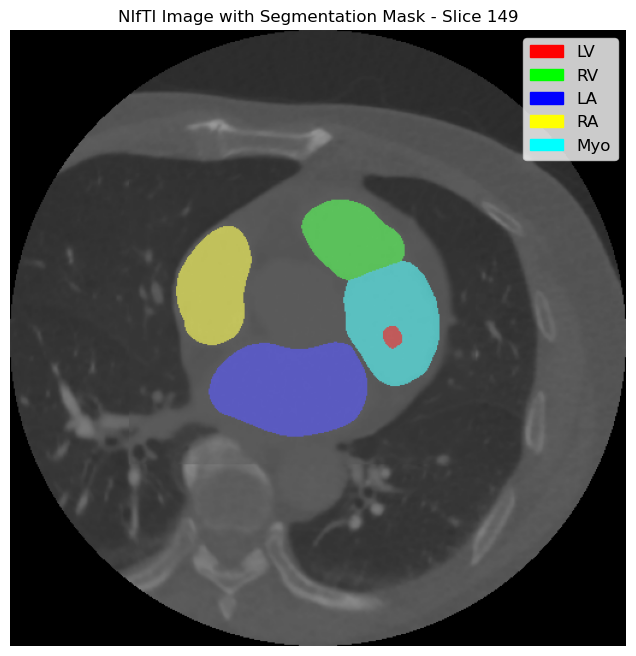

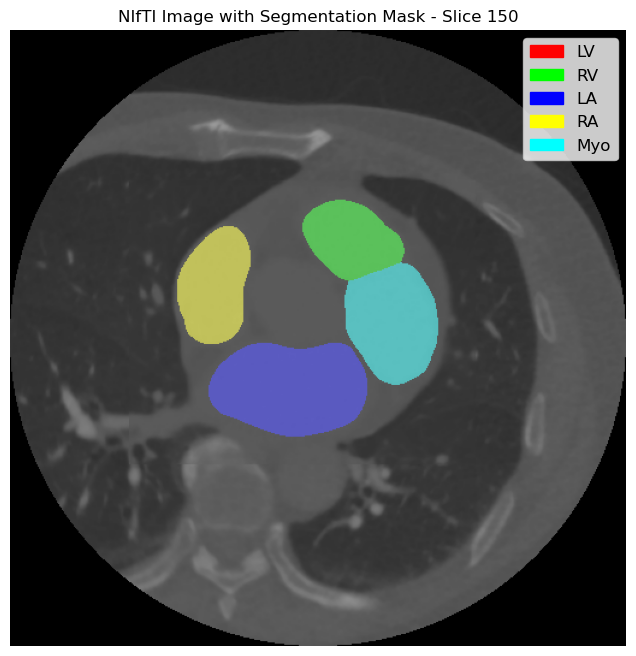

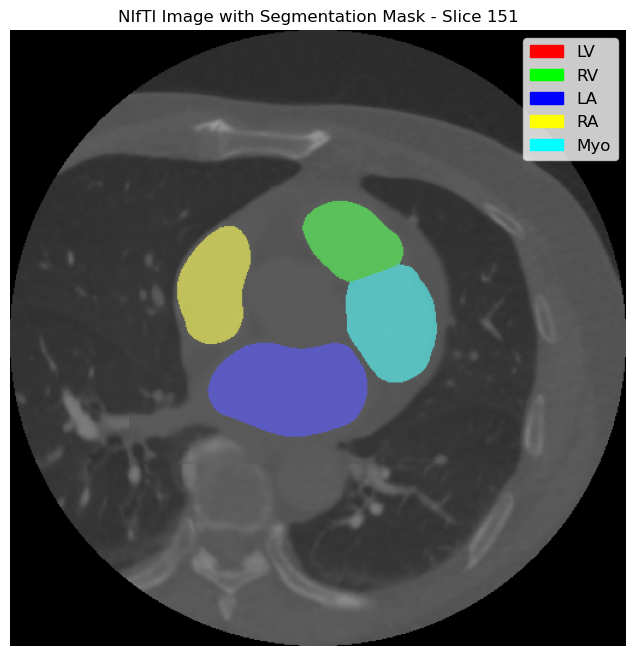

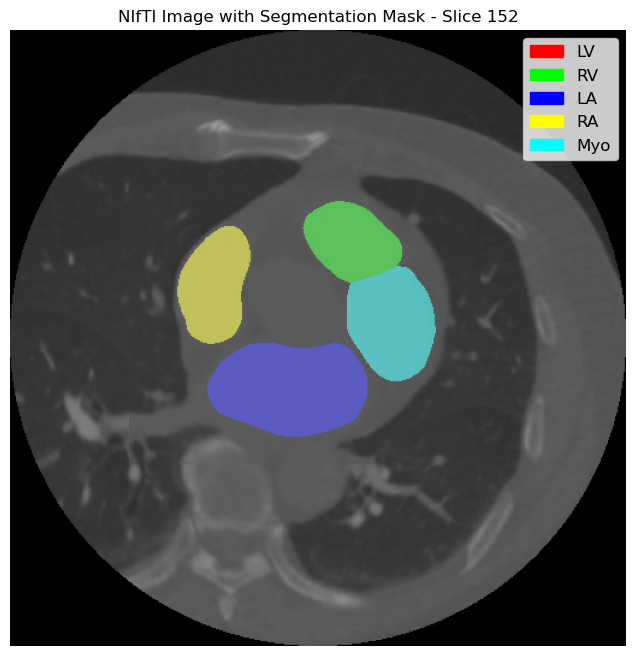

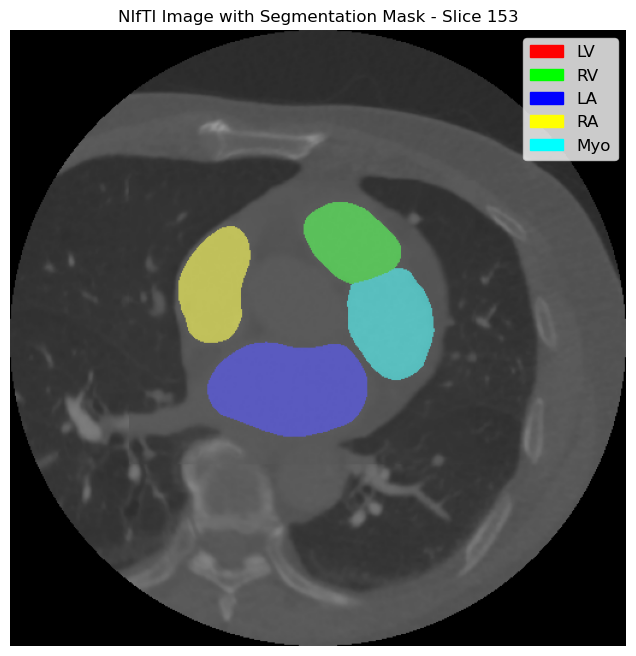

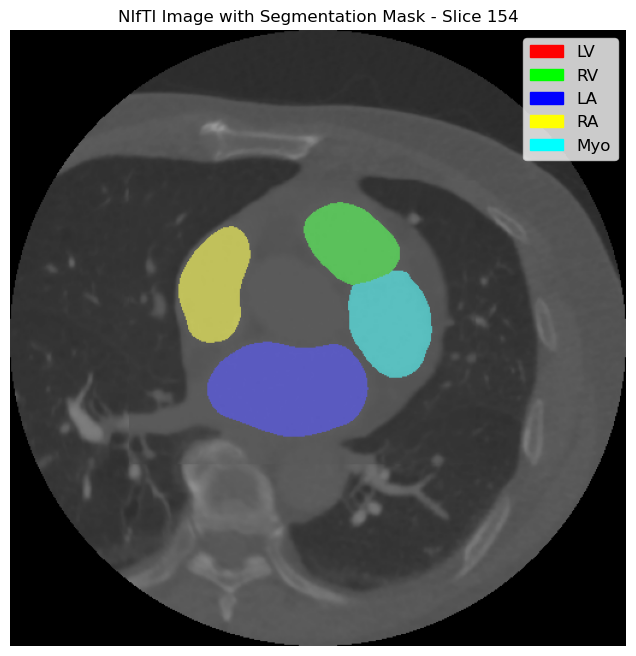

In [32]:
# Define paths to your NIfTI image and mask
image_path = r'C:\Users\qzhuang4\Desktop\cycle-transformer\results\10_rest_v2_0000.nii'
mask_path = r'C:\Users\qzhuang4\Desktop\cycle-transformer\results/ground/10_rest_v2.nii'

# Define class labels and colors (modify as per your classes)
class_labels = ['Background', 'LV', 'RV', 'LA', 'RA', 'Myo']
class_colors = [
    (0, 0, 0),        # Background - black
    (255, 0, 0),      # Class 1 - red
    (0, 255, 0),      # Class 2 - green
    (0, 0, 255),      # Class 3 - blue
    (255, 255, 0),    # Class 4 - yellow
    # (255, 0, 255),    # Class 5 - magenta
    (0, 255, 255),    # Class 6 - cyan
]

# Visualize slices from index 50 to 60
visualize_nifti_segmentation_slices(
    image_path=image_path,
    mask_path=mask_path,
    alpha=0.4,
    class_labels=class_labels,
    class_colors=class_colors,
    start_slice=145,
    end_slice=155,
    step=1  # Visualize every slice in the range
)